# The Battle of the Neighborhoods

## Open new Restaurant in Bucharest, Romania

## 1. Download and Explore Dataset

In [1]:
!pip install geopy    
!pip install folium   
!pip install geocoder
!pip install BeautifulSoup4
!pip install lxml

     |████████████████████████████████| 112kB 15.9MB/s eta 0:00:01
     |████████████████████████████████| 102kB 8.8MB/s ta 0:00:011
     |████████████████████████████████| 122kB 7.2MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 8.1MB/s eta 0:00:01     |██████████▌                     | 1.8MB 8.1MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt 
import json 

from geopy.geocoders import Nominatim 
from geopy.geocoders import Nominatim 
import geocoder 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 
from folium import plugins
from folium.plugins import HeatMap

from bs4 import BeautifulSoup 
import requests

In [3]:
bucharest_add = 'Bucharest, Romania'

In [4]:
geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_add)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_add, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


In [5]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

In [6]:
neighborhoodList = []

In [7]:
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))

In [8]:
neighborhoodList[10]

'Dorobanți'

In [9]:
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_add))

There are 40 neighborhoods in Bucharest, Romania


In [10]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')


In [11]:
sectorPopList = []
sectorPopulationList = []

In [12]:
for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0


In [13]:
df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

In [14]:
sectorNeigList =[]
sectorNeigborList =[]

In [15]:
for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])

In [16]:
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

In [17]:
print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_add))
df_sector

There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


In [18]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

In [19]:
df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


In [20]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_add))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [21]:
coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [22]:
# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.48579,26.101220
1,Băneasa,Sector 1,"225,454",44.49401,26.080372
2,Berceni,Sector 4,"287,828",44.38620,26.128960
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660


In [23]:
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

In [24]:
# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

# 2. Load Venues in Bucharest

In [25]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            'NGL3VSTVUV4IEAIYM1AJAAOZWR0QKTXMXGD1L3MOX2FMTD1I',
            'DTYFGI5DAY1ED2SSQ5P1MBHGTM5A5UCJQUK5AC1LMJI2BRM0',
            '20180604',
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 219 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.10122,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.10122,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
2,Aviației,44.48579,26.10122,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop
3,Aviației,44.48579,26.10122,ORYGYNS Specialty Coffee,5807575ed67ca95d8cf5ccb9,44.480010,26.100450,646,Coffee Shop
4,Aviației,44.48579,26.10122,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint


In [26]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,69
Restaurant,62
Coffee Shop,57
Supermarket,50
Pizza Place,49
Italian Restaurant,47
Hotel,40
Gym,38
Park,37


In [27]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
turkish_restaurant_list = ['Turkish Restaurant', 'Doner Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
turkish_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(turkish_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Turkish restaurants:', len(turkish_restaurants['VenueId'].unique()))
print('Percentage of Turkish restaurants: {:.2f}%'.format(len(turkish_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 477
Total number of Turkish restaurants: 22
Percentage of Turkish restaurants: 4.61%


20 neighborhoods do not have any Turkish restaurant


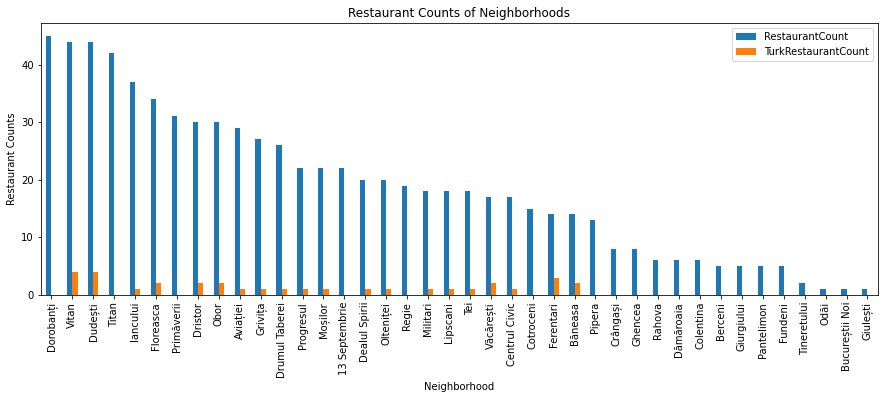

In [28]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_turk_rest_counts =  turkish_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "TurkRestaurantCount"})[['TurkRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(turkish_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_turk_rest_counts = df_turk_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'TurkRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_turk_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_turk_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Turkish restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','TurkRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()

In [29]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, 'NGL3VSTVUV4IEAIYM1AJAAOZWR0QKTXMXGD1L3MOX2FMTD1I', 'DTYFGI5DAY1ED2SSQ5P1MBHGTM5A5UCJQUK5AC1LMJI2BRM0', '20180604')
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,None,None
1,53623e44498ed583ede334f5,None,None
2,55b8a459498efbbb6ca3526d,None,None
3,58bbf8764f1069627380fed5,None,None
4,59ee47be0d8a0f244d41fca7,None,None


In [30]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,None,None
1,Floreasca,44.47633,26.103279,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,349,Burger Joint,None,None
2,Aviației,44.48579,26.101220,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,None,None
3,Floreasca,44.47633,26.103279,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,228,Restaurant,None,None
4,Aviației,44.48579,26.101220,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,None,None


In [31]:
#merge raitings to turkish restaurants 
turkish_restaurants = turkish_restaurants.merge(restaurants_raitings)
turkish_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,825,Turkish Restaurant,None,None
1,Floreasca,44.47633,26.103279,Istanbul Taksim,55acc94f498e0a64af6b19af,44.478560,26.103505,248,Turkish Restaurant,None,None
2,Băneasa,44.49401,26.080372,Shaormeria Băneasa,5137a298e4b0523475c45b54,44.494460,26.080462,50,Doner Restaurant,None,None
3,Băneasa,44.49401,26.080372,Mister Kebab,55cc98e7498eb1362730ea27,44.493982,26.082630,179,Doner Restaurant,None,None
4,Centrul Civic,44.43430,26.094660,Dristor Kebap,4dc58dd7887717c8802694a1,44.430054,26.100384,656,Doner Restaurant,None,None


In [35]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
#HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(turkish_restaurants['VenueLatitude'], turkish_restaurants['VenueLongitude'], turkish_restaurants['Neighborhood'], turkish_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = turkish_restaurants[turkish_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

In [37]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
#HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

# 3. Cluster Neigborhoods using Clustering

In [38]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 219 columns as below


,Neighborhood,Supermarket,Coffee Shop,Burger Joint,Hotel,Dessert Shop,Beer Garden,Roof Deck,Grocery Store,Gym / Fitness Center,Restaurant,Bookstore,Vietnamese Restaurant,Salad Place,Shopping Mall,Pie Shop,Salon / Barbershop,Café,Steakhouse,Sushi Restaurant,Italian Restaurant,Clothing Store,Turkish Restaurant,Lebanese Restaurant,Toy / Game Store,Bakery,Casino,Spanish Restaurant,Pizza Place,Athletics & Sports,Indoor Play Area,Event Space,Eastern European Restaurant,Lounge,Fried Chicken Joint,Chinese Restaurant,Romanian Restaurant,Stadium,Tennis Stadium,Health & Beauty Service,Food Court,Men's Store,Cocktail Bar,Nightclub,Doner Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Sandwich Place,Tunnel,Theme Restaurant,Farmers Market,Asian Restaurant,Soccer Field,Food & Drink Shop,Electronics Store,Nature Preserve,Fast Food Restaurant,Betting Shop,Metro Station,Fountain,Department Store,Gym,Gas Station,Theater,Cupcake Shop,Pharmacy,Spa,Gym Pool,Mobile Phone Shop,Shop & Service,Gastropub,Bistro,Indie Theater,Outdoor Sculpture,Monastery,Ice Cream Shop,Used Bookstore,Chocolate Shop,Plaza,Tea Room,Art Museum,Bar,Concert Hall,Wine Bar,Church,Cosmetics Shop,History Museum,Beer Bar,Boutique,Rock Club,Greek Restaurant,Hostel,Hotel Bar,Breakfast Spot,Mediterranean Restaurant,Historic Site,Art Gallery,Tattoo Parlor,Hardware Store,Discount Store,Arts & Crafts Store,Herbs & Spices Store,Bus Station,Furniture / Home Store,Gift Shop,Tennis Court,French Restaurant,Jazz Club,Accessories Store,Market,Opera House,Garden,Pedestrian Plaza,Indian Restaurant,Music Store,Pub,Pool,Indie Movie Theater,Australian Restaurant,Shoe Store,Light Rail Station,Climbing Gym,Falafel Restaurant,Soccer Stadium,Bowling Alley,Miscellaneous Shop,Smoke Shop,Convenience Store,Outlet Mall,Intersection,Mexican Restaurant,Flower Shop,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Cheese Shop,Seafood Restaurant,Modern European Restaurant,Fruit & Vegetable Store,German Restaurant,Creperie,Wine Shop,Molecular Gastronomy Restaurant,Hookah Bar,American Restaurant,Drugstore,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Skate Park,Pastry Shop,IT Services,Skating Rink,Water Park,Brewery,Ballroom,Bed & Breakfast,Playground,Health Food Store,Diner,Jewelry Store,Auto Dealership,Portuguese Restaurant,Science Museum,Sporting Goods Shop,Lingerie Store,Ramen Restaurant,Cable Car,Sports Club,Tram Station,Boxing Gym,Bagel Shop,Museum,Food Truck,Buffet,Movie Theater,Train Station,Lawyer,Paper / Office Supplies Store,Kebab Restaurant,Exhibit,Snack Place,Public Art,Pool Hall,Donut Shop,Gourmet Shop,Palace,Women's Store,Camera Store,Bridal Shop,BBQ Joint,Big Box Store,Hungarian Restaurant,Karaoke Bar,Beach,Auto Garage,Go Kart Track,Souvlaki Shop,Track,Recreation Center,Bike Shop,Dog Run,Veterinarian,Basketball Court,Sports Bar,Laundromat,Business Service,Lighting Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Racetrack,Recording Studio,ATM,Soup Place,Circus
0,13 Septembrie,1,1,0,3,1,0,0,1,3,5,0,0,0,0,0,0,3,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,3,1,0,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,2,0,0,0,0,0,1,4,2,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,1,1,1,0,0,0
1,Aviației,4,4,3,4,2,1,1,1,3,5,1,1,1,1,1,1,5,2,2,1,2,1,2,1,3,1,1,4,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berceni,1,0,0,0,0,1,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [39]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,75,Restaurant,Plaza,Gym / Fitness Center,Café,Lounge,Pub,Hotel,Bistro,Comfort Food Restaurant,Seafood Restaurant
1,Aviației,75,Café,Restaurant,Hotel,Pizza Place,Supermarket,Coffee Shop,Bakery,Burger Joint,Gym / Fitness Center,Dessert Shop
2,Berceni,21,Grocery Store,Pizza Place,Betting Shop,Gym / Fitness Center,Lebanese Restaurant,Fast Food Restaurant,Nature Preserve,Fountain,Department Store,Farmers Market
3,Bucureștii Noi,22,Supermarket,Gym,Park,Grocery Store,Gym Pool,Spa,Pharmacy,Cupcake Shop,Bakery,Theater
4,Băneasa,30,Restaurant,Doner Restaurant,Italian Restaurant,Park,Romanian Restaurant,Hotel,Athletics & Sports,Pizza Place,Nightclub,Theme Restaurant


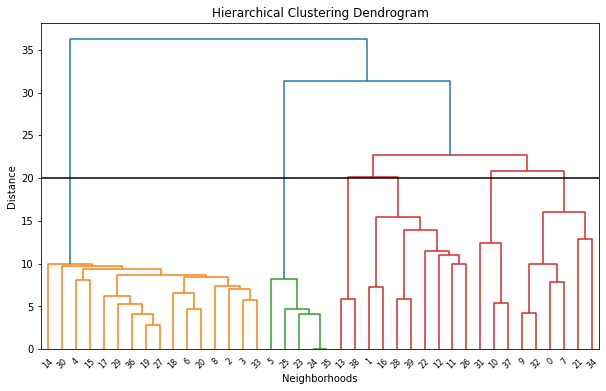

In [40]:


import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))



In [41]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()

,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.48579,26.101220,1,Café,Restaurant,Hotel
1,Băneasa,Sector 1,"225,454",44.49401,26.080372,3,Restaurant,Doner Restaurant,Italian Restaurant
2,Berceni,Sector 4,"287,828",44.38620,26.128960,3,Grocery Store,Pizza Place,Betting Shop
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494,3,Supermarket,Gym,Park
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660,2,Coffee Shop,Hotel,Theater


In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [43]:


print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})



                                                 Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                     
0                   Coffee Shop                                   1
                    Pub                                           1
                    Restaurant                                    4
1                   Café                                          1
                    Coffee Shop                                   1
                    Italian Restaurant                            2
                    Pizza Place                                   2
                    Supermarket                                   2
2                   Coffee Shop                                   5
3                   Beach                                         1
                    Burger Joint                                  2
                    Bus Station                                   3
                    Café                        

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Bus Station                                  1
                    Gym                                          1
                    Hotel                                        2
                    Plaza                                        1
                    Supermarket                                  1
1                   Burger Joint                                 1
                    Café                                         2
                    Pharmacy                                     1
                    Pizza Place                                  2
                    Restaurant                                   1
                    Supermarket                                  1
2                   Hotel                                        5
3                   Bus Station                                  2
                    Café                                         1
                    Climbing Gym                                 1
                    Doner Restaurant                             1
                    Furniture / Home Store                       1
                    Gym                                          1
                    Mobile Phone Shop                            1
                    Pedestrian Plaza                             1
                    Pizza Place                                  1
                    Pool                                         1
                    Restaurant                                   2
                    Soccer Field                                 1
                    Supermarket                                  2
4                   Coffee Shop                                  2
                    Lounge                                       1
5                   Lounge                                       1
                    Supermarket                                  1